In [1]:
from pathlib import Path
import os
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
import torch.optim as optim
from tqdm import tqdm
#%pip install --upgrade attrs



# Téléchargement des données

from datamaestro import prepare_dataset
ds = prepare_dataset("com.lecun.mnist");
train_images, train_labels = ds.train.images.data(), ds.train.labels.data()
test_images, test_labels =  ds.test.images.data(), ds.test.labels.data()

# Tensorboard : rappel, lancer dans une console tensorboard --logdir runs
writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Pour visualiser
# Les images doivent etre en format Channel (3) x Hauteur x Largeur
images = torch.tensor(train_images[0:8]).unsqueeze(1).repeat(1,3,1,1).double()/255.
# Permet de fabriquer une grille d'images
images = make_grid(images)
# Affichage avec tensorboard
writer.add_image(f'samples', images, 0)


savepath = Path("model.pch")


class MonDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.images)

2023-10-15 21:54:35.405088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 21:54:36.228071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 4.54k/4.54k [00:00<00:00, 5.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 280kB/s] 
100%|██████████| 9.91M/9.91M [00:07<00:00, 1.27MB/s]


In [2]:
print(train_images.shape)
print(test_images.shape)


(60000, 28, 28)
(10000, 28, 28)


In [4]:
num_epochs = 10
batch_sizes = [32, 128, 256]
log_interval = 100

input_size = 28 * 28  
hidden_size = 128  
output_size = 10  


for batch_size in batch_sizes:
    print("\nsize : ", batch_size)
    train_loader = DataLoader(MonDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
    
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )

    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28 * 28)/255.
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


size :  32


/home/pidoux/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


Train Epoch: 0 	Loss: 0.205389
Train Epoch: 1 	Loss: 0.117593
Train Epoch: 2 	Loss: 0.103722
Train Epoch: 3 	Loss: 0.061561
Train Epoch: 4 	Loss: 0.019130
Train Epoch: 5 	Loss: 0.006933
Train Epoch: 6 	Loss: 0.064064
Train Epoch: 7 	Loss: 0.143901
Train Epoch: 8 	Loss: 0.008265
Train Epoch: 9 	Loss: 0.005987

size :  128
Train Epoch: 0 	Loss: 0.196057
Train Epoch: 1 	Loss: 0.137015
Train Epoch: 2 	Loss: 0.067686
Train Epoch: 3 	Loss: 0.098804
Train Epoch: 4 	Loss: 0.105168
Train Epoch: 5 	Loss: 0.090326
Train Epoch: 6 	Loss: 0.127438
Train Epoch: 7 	Loss: 0.093357
Train Epoch: 8 	Loss: 0.173756
Train Epoch: 9 	Loss: 0.048117

size :  256
Train Epoch: 0 	Loss: 0.254771
Train Epoch: 1 	Loss: 0.189312
Train Epoch: 2 	Loss: 0.222605
Train Epoch: 3 	Loss: 0.180836
Train Epoch: 4 	Loss: 0.208006
Train Epoch: 5 	Loss: 0.137836
Train Epoch: 6 	Loss: 0.062540
Train Epoch: 7 	Loss: 0.068545
Train Epoch: 8 	Loss: 0.027037
Train Epoch: 9 	Loss: 0.029131


L'avantage de l'initialisation des poids du décodeur avec la transposée des poids de l'encodeur est que cela aide le modèle à converger plus rapidement. En utilisant cette initialisation, le décodeur est initialement proche de l'inverse de l'encodeur, ce qui permet une meilleure reconstruction des données lors de l'apprentissage. Cela peut accélérer la convergence de l'autoencodeur lors de l'apprentissage non supervisé.

In [40]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def initialize_weights(self):
        # Transposez les poids de l'encodeur et copiez-les dans le décodeur
        for enc_layer, dec_layer in zip(self.encoder, self.decoder):
            if isinstance(enc_layer, nn.Linear) and isinstance(dec_layer, nn.Linear):
                dec_layer.weight.data = enc_layer.weight.data.T
                dec_layer.bias.data = enc_layer.bias.data


In [50]:
class Autoencoder_sans_init(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder_sans_init, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [51]:
#parametre du modele
input_dim = 784  
encoding_dim = 32 
n_hidden = 20
lr = 0.01
batch_size = 100
iterations = 50
criterion = nn.MSELoss()

# data loader pour les données d'entrainement et de test

train_loader = DataLoader(MonDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MonDataset(test_images, test_labels), batch_size=batch_size, shuffle=True)

# device
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
print(f"running on {device}")


class State :
    def __init__(self, model, optim) :
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0,0
# charger un état précédent
savepath=Path("model5.pch")
if savepath.is_file():
    with savepath.open("rb") as fp:
        state = torch.load(fp)
#creer un nouvel état à partir d'un modèle et d'un optimiseur
else:
    model = Autoencoder_sans_init(input_dim, encoding_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    state = State(model, optimizer)

for epoch in tqdm(range(iterations)):
    for x,y in train_loader:
        x = x.reshape(-1, 28 * 28)/255.
        state.optim.zero_grad()
        x = x.to(device)
        encoded , outputs = state.model(x)
        loss = criterion(outputs, x)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        state.optim.step()
        state.iteration += 1
    with savepath.open("wb") as fp:
        state.epoch += 1
        torch.save(state, fp)
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.reshape(-1, 28 * 28)/255.
            x = x.to(device)
            encoded_test, outputs_test = model(x)
            loss_test = criterion(outputs_test, x)
            writer.add_scalar("Loss/test", loss_test, epoch)
    

running on cuda


100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


x avant encodage


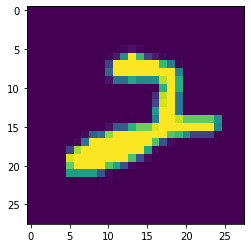

x apres encodage


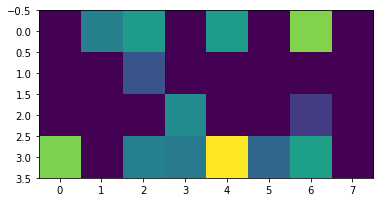

x apres decodage


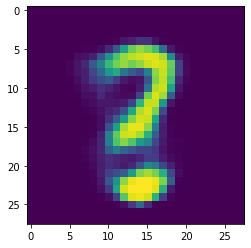

In [47]:
import matplotlib.pyplot as plt

with torch.no_grad():
    i=0
    for x, _ in test_loader:
        x = x.reshape(-1, 28 * 28)/255
        if i==0:
            print('x avant encodage')
            plt.imshow(x[0].reshape(28,28).to("cpu"))
            plt.show()
            i+=1
        x = x.to(device)
        encoded , outputs = model(x)
    print('x apres encodage')
    plt.imshow(encoded[0].reshape(4,8).to("cpu"))
    plt.show()
    print('x apres decodage')
    plt.imshow(outputs[0].reshape(28,28).to("cpu"))
    plt.show()



In [81]:
#parametre du modele
input_dim = 784  
encoding_dim = 32 
n_hidden = 20
lr = 0.01
batch_size = 100
iterations = 10
criterion = nn.MSELoss()

# data loader pour les données d'entrainement et de test

train_loader = DataLoader(MonDataset(train_images, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MonDataset(test_images, test_labels), batch_size=batch_size, shuffle=True)

# device
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
print(f"running on {device}")


class State :
    def __init__(self, model, optim) :
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0,0
# charger un état précédent
savepath=Path("model6.pch")
if savepath.is_file():
    with savepath.open("rb") as fp:
        state = torch.load(fp)
#creer un nouvel état à partir d'un modèle et d'un optimiseur
else:
    model = Autoencoder(input_dim, encoding_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    state = State(model, optimizer)

for epoch in tqdm(range(iterations)):
    for x,y in train_loader:
        x = x.reshape(-1, 28 * 28)/255.
        state.optim.zero_grad()
        x = x.to(device)
        encoded , outputs = state.model(x)
        loss = criterion(outputs, x)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        state.optim.step()
        state.iteration += 1
    with savepath.open("wb") as fp:
        state.epoch += 1
        torch.save(state, fp)
    with torch.no_grad():
        i = 0
        for x, _ in test_loader:
            x = x.reshape(-1, 28 * 28)/255.
            x = x.to(device)
            encoded_test, outputs_test = model(x)
            loss_test = criterion(outputs_test, x)
            writer.add_scalar("Loss/test", loss_test, epoch)

            image = torch.tensor(x[0:8].to('cpu')).unsqueeze(1).reshape(8,1,28,28).repeat(1,3,1,1)
            writer.add_images(f'samples', image, epoch)
            image = torch.tensor(outputs_test[0:8].to('cpu')).unsqueeze(1).reshape(8,1,28,28).repeat(1,3,1,1)
            writer.add_images(f'decoded', image, epoch)
            embedding = torch.tensor(outputs_test[0:8].to('cpu')).unsqueeze(1).reshape(8,1,28,28).repeat(1,3,1,1)
            writer.add_embedding(embedding, global_step = epoch, tag = f'encoded')
            i+=1

running on cuda


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_43089/2173379003.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(x[0:8].to('cpu')).unsqueeze(1).reshape(8,1,28,28).repeat(1,3,1,1)
/tmp/ipykernel_43089/2173379003.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(outputs_test[0:8].to('cpu')).unsqueeze(1).reshape(8,1,28,28).repeat(1,3,1,1)
100%|██████████| 10/10 [00:33<00:00,  3.38s/it]
